The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.14.0
!pip install -U mxnet-cu101mkl==1.6.0  # updating mxnet to at least v1.6


# Neural Style Transfer

If you use social sharing apps or happen to be an amateur photographer, you are familiar with filters. Filters can alter the color styles of photos to make the background sharper or people's faces whiter. However, a filter generally can only change one aspect of a photo. To create the ideal photo, you often need to try many different filter combinations. This process is as complex as tuning the hyper-parameters of a model.

In this section, we will discuss how we can use convolution neural networks
(CNNs) to automatically apply the style of one image to another image, an
operation known as style transfer :cite:`Gatys.Ecker.Bethge.2016`. Here, we need two input images, one content image and one style image. We use a neural network to alter the content image so that its style mirrors that of the style image. In :numref:`fig_style_transfer`, the content image is a landscape photo the author took in Mount Rainier National Part near Seattle. The style image is an oil painting of oak trees in autumn. The output composite image retains the overall shapes of the objects in the content image, but applies the oil painting brushwork of the style image and makes the overall color more vivid.

![Content and style input images and composite image produced by style transfer. ](../img/style-transfer.svg)
:label:`fig_style_transfer`

## Technique

The CNN-based style transfer model is shown in :numref:`fig_style_transfer_model`.
First, we initialize the composite image. For example, we can initialize it as the content image. This composite image is the only variable that needs to be updated in the style transfer process, i.e., the model parameter to be updated in style transfer. Then, we select a pre-trained CNN to extract image features. These model parameters do not need to be updated during training. The deep CNN uses multiple neural layers that successively extract image features. We can select the output of certain layers to use as content features or style features. If we use the structure in :numref:`fig_style_transfer_model`, the pre-trained neural network contains three convolutional layers. The second layer outputs the image content features, while the outputs of the first and third layers are used as style features. Next, we use forward propagation (in the direction of the solid lines) to compute the style transfer loss function and backward propagation (in the direction of the dotted lines) to update the model parameter, constantly updating the composite image. The loss functions used in style transfer generally have three parts: 1. Content loss is used to make the composite image approximate the content image as regards content features. 2. Style loss is used to make the composite image approximate the style image in terms of style features. 3. Total variation loss helps reduce the noise in the composite image. Finally, after we finish training the model, we output the style transfer model parameters to obtain the final composite image.

![CNN-based style transfer process. Solid lines show the direction of forward propagation and dotted lines show backward propagation. ](../img/neural-style.svg)
:label:`fig_style_transfer_model`


Next, we will perform an experiment to help us better understand the technical details of style transfer.

## Reading the Content and Style Images

First, we read the content and style images. By printing out the image coordinate axes, we can see that they have different dimensions.


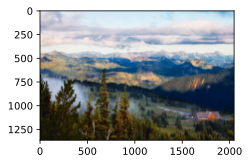

In [1]:
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import autograd, gluon, image, init, np, npx
from mxnet.gluon import nn

npx.set_np()

d2l.set_figsize()
content_img = image.imread('../img/rainier.jpg')
d2l.plt.imshow(content_img.asnumpy());

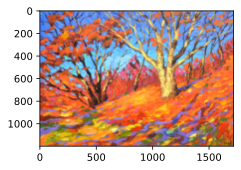

In [2]:
style_img = image.imread('../img/autumn_oak.jpg')
d2l.plt.imshow(style_img.asnumpy());

## Preprocessing and Postprocessing

Below, we define the functions for image preprocessing and postprocessing. The `preprocess` function normalizes each of the three RGB channels of the input images and transforms the results to a format that can be input to the CNN. The `postprocess` function restores the pixel values in the output image to their original values before normalization. Because the image printing function requires that each pixel has a floating point value from 0 to 1, we use the `clip` function to replace values smaller than 0 or greater than 1 with 0 or 1, respectively.


In [3]:
rgb_mean = np.array([0.485, 0.456, 0.406])
rgb_std = np.array([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    img = image.imresize(img, *image_shape)
    img = (img.astype('float32') / 255 - rgb_mean) / rgb_std
    return np.expand_dims(img.transpose(2, 0, 1), axis=0)

def postprocess(img):
    img = img[0].as_in_ctx(rgb_std.ctx)
    return (img.transpose(1, 2, 0) * rgb_std + rgb_mean).clip(0, 1)

## Extracting Features

We use the VGG-19 model pre-trained on the ImageNet dataset to extract image features[1].


In [4]:
pretrained_net = gluon.model_zoo.vision.vgg19(pretrained=True)

To extract image content and style features, we can select the outputs of certain layers in the VGG network. In general, the closer an output is to the input layer, the easier it is to extract image detail information. The farther away an output is, the easier it is to extract global information. To prevent the composite image from retaining too many details from the content image, we select a VGG network layer near the output layer to output the image content features. This layer is called the content layer. We also select the outputs of different layers from the VGG network for matching local and global styles. These are called the style layers. As we mentioned in :numref:`sec_vgg`, VGG networks have five convolutional blocks. In this experiment, we select the last convolutional layer of the fourth convolutional block as the content layer and the first layer of each block as style layers. We can obtain the indexes for these layers by printing the `pretrained_net` instance.


In [5]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

During feature extraction, we only need to use all the VGG layers from the input layer to the content or style layer nearest the output layer. Below, we build a new network, `net`, which only retains the layers in the VGG network we need to use. We then use `net` to extract features.


In [6]:
net = nn.Sequential()
for i in range(max(content_layers + style_layers) + 1):
    net.add(pretrained_net.features[i])

Given input `X`, if we simply call the forward computation `net(X)`, we can only obtain the output of the last layer. Because we also need the outputs of the intermediate layers, we need to perform layer-by-layer computation and retain the content and style layer outputs.


In [7]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

Next, we define two functions: The `get_contents` function obtains the content features extracted from the content image, while the `get_styles` function obtains the style features extracted from the style image. Because we do not need to change the parameters of the pre-trained VGG model during training, we can extract the content features from the content image and style features from the style image before the start of training. As the composite image is the model parameter that must be updated during style transfer, we can only call the `extract_features` function during training to extract the content and style features of the composite image.


In [8]:
def get_contents(image_shape, ctx):
    content_X = preprocess(content_img, image_shape).copyto(ctx)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, ctx):
    style_X = preprocess(style_img, image_shape).copyto(ctx)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

## Defining the Loss Function

Next, we will look at the loss function used for style transfer. The loss function includes the content loss, style loss, and total variation loss.

### Content Loss

Similar to the loss function used in linear regression, content loss uses a square error function to measure the difference in content features between the composite image and content image. The two inputs of the square error function are both content layer outputs obtained from the `extract_features` function.


In [9]:
def content_loss(Y_hat, Y):
    return np.square(Y_hat - Y).mean()

### Style Loss

Style loss, similar to content loss, uses a square error function to measure the difference in style between the composite image and style image. To express the styles output by the style layers, we first use the `extract_features` function to compute the style layer output. Assuming that the output has 1 example, $c$ channels, and a height and width of $h$ and $w$, we can transform the output into the matrix $\mathbf{X}$, which has $c$ rows and $h \cdot w$ columns. You can think of matrix $\mathbf{X}$ as the combination of the $c$ vectors $\mathbf{x}_1, \ldots, \mathbf{x}_c$, which have a length of $hw$. Here, the vector $\mathbf{x}_i$ represents the style feature of channel $i$. In the Gram matrix of these vectors $\mathbf{X}\mathbf{X}^\top \in \mathbb{R}^{c \times c}$, element $x_{ij}$ in row $i$ column $j$ is the inner product of vectors $\mathbf{x}_i$ and $\mathbf{x}_j$. It represents the correlation of the style features of channels $i$ and $j$. We use this type of Gram matrix to represent the style output by the style layers. You must note that, when the $h \cdot w$ value is large, this often leads to large values in the Gram matrix. In addition, the height and width of the Gram matrix are both the number of channels $c$. To ensure that the style loss is not affected by the size of these values, we define the `gram` function below to divide the Gram matrix by the number of its elements, i.e., $c \cdot h \cdot w$.


In [10]:
def gram(X):
    num_channels, n = X.shape[1], X.size // X.shape[1]
    X = X.reshape(num_channels, n)
    return np.dot(X, X.T) / (num_channels * n)

Naturally, the two Gram matrix inputs of the square error function for style loss are taken from the composite image and style image style layer outputs. Here, we assume that the Gram matrix of the style image, `gram_Y`, has been computed in advance.


In [11]:
def style_loss(Y_hat, gram_Y):
    return np.square(gram(Y_hat) - gram_Y).mean()

### Total Variance Loss

Sometimes, the composite images we learn have a lot of high-frequency noise, particularly bright or dark pixels. One common noise reduction method is total variation denoising. We assume that $x_{i, j}$ represents the pixel value at the coordinate $(i, j)$, so the total variance loss is:

$$\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \left|x_{i, j} - x_{i, j+1}\right|.$$

We try to make the values of neighboring pixels as similar as possible.


In [12]:
def tv_loss(Y_hat):
    return 0.5 * (np.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  np.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

### The Loss Function

The loss function for style transfer is the weighted sum of the content loss, style loss, and total variance loss. By adjusting these weight hyper-parameters, we can balance the retained content, transferred style, and noise reduction in the composite image according to their relative importance.


In [13]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # Calculate the content, style, and total variance losses respectively
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # Add up all the losses
    l = sum(styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

## Creating and Initializing the Composite Image

In style transfer, the composite image is the only variable that needs to be updated. Therefore, we can define a simple model, `GeneratedImage`, and treat the composite image as a model parameter. In the model, forward computation only returns the model parameter.


In [14]:
class GeneratedImage(nn.Block):
    def __init__(self, img_shape, **kwargs):
        super(GeneratedImage, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=img_shape)

    def forward(self):
        return self.weight.data()

Next, we define the `get_inits` function. This function creates a composite image model instance and initializes it to the image `X`. The Gram matrix for the various style layers of the style image, `styles_Y_gram`, is computed prior to training.


In [15]:
def get_inits(X, ctx, lr, styles_Y):
    gen_img = GeneratedImage(X.shape)
    gen_img.initialize(init.Constant(X), ctx=ctx, force_reinit=True)
    trainer = gluon.Trainer(gen_img.collect_params(), 'adam',
                            {'learning_rate': lr})
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

## Training

During model training, we constantly extract the content and style features of
the composite image and calculate the loss function. Recall our discussion of
how synchronization functions force the front end to wait for computation
results in :numref:`sec_async`. Because we only call the `asscalar` synchronization function every 50
epochs, the process may occupy a great deal of memory. Therefore, we call the
`waitall` synchronization function during every epoch.


In [16]:
def train(X, contents_Y, styles_Y, ctx, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, ctx, lr, styles_Y)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(1, num_epochs+1):
        with autograd.record():
            contents_Y_hat, styles_Y_hat = extract_features(
                X, content_layers, style_layers)
            contents_l, styles_l, tv_l, l = compute_loss(
                X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step(1)
        npx.waitall()
        if epoch % lr_decay_epoch == 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.1)
        if epoch % 10 == 0:
            animator.axes[1].imshow(postprocess(X).asnumpy())
            animator.add(epoch, [float(sum(contents_l)),
                                 float(sum(styles_l)),
                                 float(tv_l)])
    return X

Next, we start to train the model. First, we set the height and width of the content and style images to 150 by 225 pixels. We use the content image to initialize the composite image.


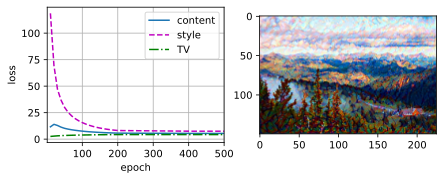

In [17]:
ctx, image_shape = d2l.try_gpu(), (225, 150)
net.collect_params().reset_ctx(ctx)
content_X, contents_Y = get_contents(image_shape, ctx)
_, styles_Y = get_styles(image_shape, ctx)
output = train(content_X, contents_Y, styles_Y, ctx, 0.01, 500, 200)

As you can see, the composite image retains the scenery and objects of the content image, while introducing the color of the style image. Because the image is relatively small, the details are a bit fuzzy.

To obtain a clearer composite image, we train the model using a larger image size: $900 \times 600$. We increase the height and width of the image used before by a factor of four and initialize a larger composite image.


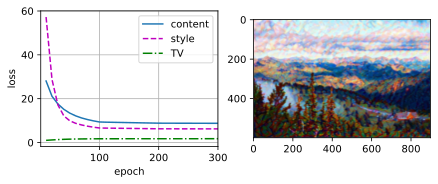

In [18]:
image_shape = (900, 600)
_, content_Y = get_contents(image_shape, ctx)
_, style_Y = get_styles(image_shape, ctx)
X = preprocess(postprocess(output) * 255, image_shape)
output = train(X, content_Y, style_Y, ctx, 0.01, 300, 100)
d2l.plt.imsave('../img/neural-style.png', postprocess(output).asnumpy())

As you can see, each epoch takes more time due to the larger image size. As shown in :numref:`fig_style_transfer_large`, the composite image produced retains more detail due to its larger size. The composite image not only has large blocks of color like the style image, but these blocks even have the subtle texture of brush strokes.

![$900 \times 600$ composite image. ](../img/neural-style.png)
:width:`500px`
:label:`fig_style_transfer_large`

## Summary

* The loss functions used in style transfer generally have three parts: 1. Content loss is used to make the composite image approximate the content image as regards content features. 2. Style loss is used to make the composite image approximate the style image in terms of style features. 3. Total variation loss helps reduce the noise in the composite image.
* We can use a pre-trained CNN to extract image features and minimize the loss function to continuously update the composite image.
* We use a Gram matrix to represent the style output by the style layers.


## Exercises

1. How does the output change when you select different content and style layers?
1. Adjust the weight hyper-parameters in the loss function. Does the output retain more content or have less noise?
1. Use different content and style images. Can you create more interesting composite images?


[Discussions](https://discuss.d2l.ai/t/378)
